## Comparison with Lab Dataset

### Import libraries

In [1]:
import os
import pandas as pd 
import numpy as np
from lxml import etree 
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 200
import os
import glob
import time
import re
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import matplotlib.patches as mpatches
import shutil
from IPython.display import clear_output
pd.set_option('display.max_rows', 500)
from manuf import manuf
from user_agents import parse
import dataframe_image as dfi
import tldextract
import random
import matplotlib

### Readin datasets

In [2]:
iot = pd.read_parquet("../datasets/ny_serv_withcrt.parquet")

In [3]:
names = pd.read_parquet("../datasets/sni_used_to_generate_pcaps.parquet")

### Merge to obtain device info

In [4]:
iot = pd.merge(iot, names, how='left', left_on='server_name_indication', right_on='sni')

### Readin Lab Dataset

In [5]:
target_dir = "../datasets/lab_ssl/"

In [6]:
file_lis = os.listdir(target_dir)

In [7]:
lab_zeek = pd.DataFrame()
for file in file_lis:
    curr_ssl = pd.read_csv(os.path.join(target_dir, file), index_col=0)
    lab_zeek = lab_zeek.append(curr_ssl)
print ("finished!")

/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (31) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


finished!


### Discard interception/injected data from Lab Dataset

In [8]:
lab_zeek.shape

(455519, 50)

In [9]:
lab_filter = lab_zeek.loc[lab_zeek['issuer_O'] != "mitmproxy"]

In [10]:
lab_filter.shape

(455519, 50)

In [11]:
lab_filter = lab_filter.loc[lab_filter['certificate.serial'].notna()]
lab_filter["serial_strcnt"] = lab_filter['certificate.serial'].map(len)

In [12]:
lab_filter = lab_filter.loc[(~lab_filter['certificate.serial'].str.startswith("0EA")) & \
                            (lab_filter['serial_strcnt'] != 12)]
lab_filter = lab_filter.loc[(~lab_filter['certificate.serial'].str.startswith("0A")) & \
                            (lab_filter['serial_strcnt'] != 8)]

In [13]:
lab_filter.shape

(61283, 51)

In [14]:
lab_filter.loc[lab_filter['server_name'] == '-'].shape

(7966, 51)

In [15]:
lab_filter = lab_filter.rename({'vendor':'device_vendor'}, axis=1)

### Common vendor

In [17]:
set(iot['device_vendor'].tolist()).intersection(set(lab_filter['device_vendor'].tolist()))

{'amazon',
 'amcrest',
 'belkin',
 'google',
 'ikea',
 'lg',
 'nintendo',
 'philips',
 'roku',
 'samsung',
 'tivo',
 'tplink',
 'tuya',
 'wink',
 'withings',
 'wyze',
 'xiaomi'}

In [18]:
vendor_lis = ['amazon', 'amcrest', 'belkin', 'google', 'ikea', 'nintendo', 'lg', 'philips', 'roku',\
              'samsung', 'tivo', 'tplink', 'tuya', 'wink', 'withings', 'wyze', 'xiaomi']

In [19]:
iot.loc[iot['device_vendor'].isin(vendor_lis)].shape

(293518, 123)

In [20]:
lab_filter.loc[lab_filter['device_vendor'].isin(vendor_lis)].shape

(52772, 51)

In [21]:
iot_share = iot.loc[iot['device_vendor'].isin(vendor_lis)]

In [23]:
lab_share = lab_filter.loc[lab_filter['device_vendor'].isin(vendor_lis)]

In [24]:
lab_share['issuer_O'] = lab_share['issuer_O'].apply(lambda x: x.split("\\\\")[0])

<ipython-input-24-11816eea40ca>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lab_share['issuer_O'] = lab_share['issuer_O'].apply(lambda x: x.split("\\\\")[0])


### Comparison

In [25]:
iot_share_dropdup = iot_share.drop_duplicates(subset=['server_name_indication', 'device_vendor', 'device_id', \
                                                      'cert_serialNum_from_x509af', 'issuer_O', 'issuer_CN'])

In [26]:
iot_share_dropdup.shape

(19444, 123)

In [27]:
iot_vendorgb = iot_share_dropdup.groupby(['device_vendor'])['issuer_O'].agg(iot_issuer=lambda x: set(x), \
                                                                            iot_numissuer=lambda x: x.nunique()).reset_index()

In [28]:
#neu_share = neu_share.rename({'vendor':'device_vendor'}, axis=1)
lab_share_dropdup = lab_share.drop_duplicates(subset=['server_name', 'device_vendor', 'mac', \
                                                      'validation_status', 'cert_chain_fps', 'issuer_O', 'issuer_CN'])

In [29]:
lab_share_dropdup.shape

(5279, 51)

### SNI analysis

#### Rename

In [30]:
iot_share_dropdup.loc[iot_share_dropdup.device_vendor=='tuya', 'issuer_O'] ="Tuya Global Inc."

/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [31]:
iot_share_dropdup['server_name_indication'].value_counts().shape

(989,)

In [35]:
lab_share_sni = lab_share_dropdup.loc[lab_share_dropdup['server_name'] != '-']

In [36]:
lab_share_sni['server_name'].value_counts().shape

(1443,)

In [38]:
sni_commlis = set(iot_share_dropdup['server_name_indication'].tolist()).intersection(set(lab_share_sni['server_name'].tolist()))

In [39]:
len(sni_commlis)

362

In [40]:
lab_share_sni.shape

(4778, 51)

### Different SNIs

In [41]:
iot_share_diffsni = iot_share_dropdup.loc[~iot_share_dropdup['server_name_indication'].isin(sni_commlis)]
lab_share_diffsni = lab_share_sni.loc[~lab_share_sni['server_name'].isin(sni_commlis)]

In [42]:
lab_share_diffsni = lab_share_diffsni.loc[lab_share_diffsni['server_name'] != "-"]

In [43]:
lab_share_diffsni.shape

(1736, 51)

In [44]:
iot_share_diffsni['domain'] = iot_share_diffsni['server_name_indication'].apply(lambda x: "{}.{}".format(tldextract.extract(x).domain,\
                                                                                                        tldextract.extract(x).suffix))
lab_share_diffsni['domain'] = lab_share_diffsni['server_name'].apply(lambda x: "{}.{}".format(tldextract.extract(x).domain,\
                                                                                              tldextract.extract(x).suffix))

<ipython-input-44-0c2dac20961b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iot_share_diffsni['domain'] = iot_share_diffsni['server_name_indication'].apply(lambda x: "{}.{}".format(tldextract.extract(x).domain,\


In [56]:
iot_share_diffsni['domain'].value_counts().shape

(256,)

In [45]:
lab_share_diffsni['domain'].value_counts().shape

(246,)

In [46]:
dom_commlis = set(iot_share_diffsni['domain'].tolist()).intersection(set(lab_share_diffsni['domain'].tolist()))

In [47]:
len(dom_commlis)

67

In [48]:
iot_share_diffsni.loc[iot_share_diffsni['domain'].isin(dom_commlis)]['server_name_indication'].value_counts().shape

(269,)

In [49]:
commdom_snilis = list(set(iot_share_diffsni.loc[iot_share_diffsni['domain'].isin(dom_commlis)]['server_name_indication'].tolist()))

In [50]:
len(commdom_snilis)

269

In [51]:
commdom_domlist = list(set(iot_share_diffsni.loc[iot_share_diffsni['domain'].isin(dom_commlis)]['domain'].tolist()))

In [52]:
len(commdom_domlist)

67

In [53]:
iot_share_diffsni.loc[iot_share_diffsni['domain'].isin(dom_commlis)]['device_vendor'].value_counts().shape

(14,)

In [59]:
iot_share_commdom = iot_share_diffsni.loc[iot_share_diffsni['domain'].isin(dom_commlis)]
lab_share_commdom = lab_share_diffsni.loc[lab_share_diffsni['domain'].isin(dom_commlis)]

#### Definitions

In [60]:
samsung_comm = ["DigiCert Inc", "Netflix", "Sectigo Limited", "COMODO CA Limited", "GoDaddy.com", \
                    "GlobalSign nv-sa", "Amazon", "Google Trust Services LLC", "Universal Electronics Inc", "Entrust", "Netflix Inc", "Samsung Electronics"]
amazon_comm = ["Cloudflare", "DigiCert Inc", "Netflix", "Sectigo Limited", "COMODO CA Limited", "GoDaddy.com", \
                   "GlobalSign nv-sa", "Let's Encrypt", "Amazon", "Google Trust Services LLC", "Entrust", "Netflix Inc"]
lg_comm = ["Netflix", "DigiCert Inc", "Sectigo Limited", "Microsoft Corporation", "GoDaddy.com", "LG Electronics Inc.", \
               "GlobalSign nv-sa", "Let's Encrypt", "Amazon", "Entrust", "Google Trust Services LLC", "Netflix Inc", "Network Solutions L.L.C."]
roku_comm = ["DigiCert Inc", "Netflix", "Sectigo Limited", "COMODO CA Limited", "Let's Encrypt", "Amazon", "Netflix Inc", "Roku", "Network Solutions L.L.C."]
tivo_comm = ["Netflix", "DigiCert Inc", "Sectigo Limited", "GoDaddy.com", "Amazon", "Google Trust Services LLC"]
google_comm = ["DigiCert Inc", "GlobalSign nv-sa", "Let's Encrypt", "Amazon", "Google Trust Services LLC"]
wink_comm = ["Sectigo Limited", "Let's Encrypt", "COMODO CA Limited", "DigiCert Inc"]
xiaomi_comm = []
philips_comm = ["ZeroSSL", "Philips Hue", "DigiCert Inc", "Google Trust Services LLC"]
amcrest_comm = ["GoDaddy.com"]
nintendo_comm = ["Nintendo of America", "DigiCert Inc", "Nintendo of America Inc.", "Amazon"]
tplink_comm = ["GoDaddy.com", "DigiCert Inc"]
ikea_comm = ["Amazon"]
withings_comm = []
wyze_comm = ["DigiCert Inc", "Amazon"]
belkin_comm = ["DigiCert Inc"]
tuya_comm = ["Tuya Global Inc."]

In [61]:
iot_samsung_commdom = iot_share_commdom.loc[(iot_share_commdom['device_vendor'] == 'samsung') &\
                                             (iot_share_commdom['issuer_O'].isin(samsung_comm))]
iot_amazon_commdom = iot_share_commdom.loc[(iot_share_commdom['device_vendor'] == 'amazon')& \
                                   (iot_share_commdom['issuer_O'].isin(amazon_comm))]
iot_lg_commdom = iot_share_commdom.loc[(iot_share_commdom['device_vendor'] == 'lg') & \
                               (iot_share_commdom['issuer_O'].isin(lg_comm))]
iot_roku_commdom = iot_share_commdom.loc[(iot_share_commdom['device_vendor'] == 'roku') & \
                                 (iot_share_commdom['issuer_O'].isin(roku_comm))]
iot_tivo_commdom = iot_share_commdom.loc[(iot_share_commdom['device_vendor'] == 'tivo') & \
                                 (iot_share_commdom['issuer_O'].isin(tivo_comm))]
iot_google_commdom = iot_share_commdom.loc[(iot_share_commdom['device_vendor'] == 'google') & \
                                   (iot_share_commdom['issuer_O'].isin(google_comm))]
iot_wink_commdom = iot_share_commdom.loc[(iot_share_commdom['device_vendor'] == 'wink') & \
                                 (iot_share_commdom['issuer_O'].isin(wink_comm))]
iot_xiaomi_commdom = iot_share_commdom.loc[(iot_share_commdom['device_vendor'] == 'xiaomi') & \
                                   (iot_share_commdom['issuer_O'].isin(xiaomi_comm))]
iot_philips_commdom = iot_share_commdom.loc[(iot_share_commdom['device_vendor'] == 'philips') & \
                                    (iot_share_commdom['issuer_O'].isin(philips_comm))]
iot_amcrest_commdom = iot_share_commdom.loc[(iot_share_commdom['device_vendor'] == 'amcrest') & \
                                    (iot_share_commdom['issuer_O'].isin(amcrest_comm))]
iot_nintendo_commdom = iot_share_commdom.loc[(iot_share_commdom['device_vendor'] == 'nintendo') & \
                                     (iot_share_commdom['issuer_O'].isin(nintendo_comm))]
iot_tplink_commdom = iot_share_commdom.loc[(iot_share_commdom['device_vendor'] == 'tplink') & \
                                   (iot_share_commdom['issuer_O'].isin(tplink_comm))]
iot_ikea_commdom = iot_share_commdom.loc[(iot_share_commdom['device_vendor'] == 'ikea') & \
                                 (iot_share_commdom['issuer_O'].isin(ikea_comm))]
iot_withings_commdom = iot_share_commdom.loc[(iot_share_commdom['device_vendor'] == 'withings') & \
                                     (iot_share_commdom['issuer_O'].isin(withings_comm))]
iot_wyze_commdom = iot_share_commdom.loc[(iot_share_commdom['device_vendor'] == 'wyze') & \
                                 (iot_share_commdom['issuer_O'].isin(wyze_comm))]
iot_belkin_commdom = iot_share_commdom.loc[(iot_share_commdom['device_vendor'] == 'belkin') & \
                                   (iot_share_commdom['issuer_O'].isin(belkin_comm))]
iot_tuya_commdom = iot_share_commdom.loc[(iot_share_commdom['device_vendor'] == 'tuya') & \
                                 (iot_share_commdom['issuer_O'].isin(tuya_comm))]

In [62]:
lab_samsung_commdom = lab_share_commdom.loc[(lab_share_commdom['device_vendor'] == 'samsung') & \
                                             (lab_share_commdom['issuer_O'].isin(samsung_comm))]
lab_amazon_commdom = lab_share_commdom.loc[(lab_share_commdom['device_vendor'] == 'amazon') & \
                                            (lab_share_commdom['issuer_O'].isin(amazon_comm))]
lab_lg_commdom = lab_share_commdom.loc[(lab_share_commdom['device_vendor'] == 'lg') & \
                                        (lab_share_commdom['issuer_O'].isin(lg_comm))]
lab_roku_commdom = lab_share_commdom.loc[(lab_share_commdom['device_vendor'] == 'roku') & \
                                          (lab_share_commdom['issuer_O'].isin(roku_comm))]
lab_tivo_commdom = lab_share_commdom.loc[(lab_share_commdom['device_vendor'] == 'tivo') & \
                                          (lab_share_commdom['issuer_O'].isin(tivo_comm))]
lab_google_commdom = lab_share_commdom.loc[(lab_share_commdom['device_vendor'] == 'google') & \
                                            (lab_share_commdom['issuer_O'].isin(google_comm))]
lab_wink_commdom = lab_share_commdom.loc[(lab_share_commdom['device_vendor'] == 'wink') & \
                                          (lab_share_commdom['issuer_O'].isin(wink_comm))]
lab_xiaomi_commdom = lab_share_commdom.loc[(lab_share_commdom['device_vendor'] == 'xiaomi') & \
                                            (lab_share_commdom['issuer_O'].isin(xiaomi_comm))]
lab_philips_commdom = lab_share_commdom.loc[(lab_share_commdom['device_vendor'] == 'philips') & \
                                             (lab_share_commdom['issuer_O'].isin(philips_comm))]
lab_amcrest_commdom = lab_share_commdom.loc[(lab_share_commdom['device_vendor'] == 'amcrest') & \
                                             (lab_share_commdom['issuer_O'].isin(amcrest_comm))]
lab_nintendo_commdom = lab_share_commdom.loc[(lab_share_commdom['device_vendor'] == 'nintendo') & \
                                              (lab_share_commdom['issuer_O'].isin(nintendo_comm))]
lab_tplink_commdom = lab_share_commdom.loc[(lab_share_commdom['device_vendor'] == 'tplink') & \
                                            (lab_share_commdom['issuer_O'].isin(tplink_comm))]
lab_ikea_commdom = lab_share_commdom.loc[(lab_share_commdom['device_vendor'] == 'ikea') & \
                                          (lab_share_commdom['issuer_O'].isin(ikea_comm))]
lab_withings_commdom = lab_share_commdom.loc[(lab_share_commdom['device_vendor'] == 'withings') & \
                                              (lab_share_commdom['issuer_O'].isin(withings_comm))]
lab_wyze_commdom = lab_share_commdom.loc[(lab_share_commdom['device_vendor'] == 'wyze') & \
                                          (lab_share_commdom['issuer_O'].isin(wyze_comm))]
lab_belkin_commdom = lab_share_commdom.loc[(lab_share_commdom['device_vendor'] == 'belkin') & \
                                            (lab_share_commdom['issuer_O'].isin(belkin_comm))]
lab_tuya_commdom = lab_share_commdom.loc[(lab_share_commdom['device_vendor'] == 'tuya') & \
                                          (lab_share_commdom['issuer_O'].isin(tuya_comm))]

In [63]:
iot_commdom = pd.concat([iot_samsung_commdom, iot_amazon_commdom, iot_lg_commdom, \
                         iot_roku_commdom, iot_tivo_commdom, iot_google_commdom, iot_wink_commdom, iot_xiaomi_commdom, \
                         iot_philips_commdom, iot_amcrest_commdom, iot_nintendo_commdom, iot_tplink_commdom,\
                          iot_ikea_commdom, iot_withings_commdom, iot_wyze_commdom, iot_belkin_commdom, \
                          iot_tuya_commdom], ignore_index=True)

In [64]:
iot_commdom['domain'].value_counts().shape

(66,)

In [66]:
lab_commdom = pd.concat([lab_samsung_commdom, lab_amazon_commdom, lab_lg_commdom, \
                          lab_roku_commdom, lab_tivo_commdom, lab_google_commdom, lab_wink_commdom,\
                          lab_xiaomi_commdom, lab_philips_commdom, lab_amcrest_commdom, lab_nintendo_commdom, \
                          lab_tplink_commdom, lab_ikea_commdom, lab_withings_commdom, lab_wyze_commdom, lab_belkin_commdom, \
                          lab_tuya_commdom], ignore_index=True)

In [67]:
commdomissuer_snilis = list(set(iot_commdom['server_name_indication'].tolist()))

In [68]:
len(commdomissuer_snilis)

260

In [69]:
commdomissuer_domlis = list(set(iot_commdom['domain'].tolist()))

In [70]:
len(commdomissuer_domlis)

66

In [71]:
diffissuer_2dom = list(set(commdom_domlist).difference(set(commdomissuer_domlis)))

In [72]:
len(diffissuer_2dom)

1

In [73]:
iot_share_diffsni.loc[iot_share_diffsni['domain'].isin(diffissuer_2dom)][['server_name_indication', 'issuer_CN', 'issuer_O', \
                                                                          'cert_sortedtime', 'response', 'device_vendor']]

,server_name_indication,issuer_CN,issuer_O,cert_sortedtime,response,device_vendor
21653,scalews.withings.net,Gandi Standard SSL CA 2,Gandi,"['2021-07-12 00:00:00 (UTC)', '2022-08-10 23:59:59 (UTC)']",True,withings
21654,scalews.withings.net,Gandi Standard SSL CA 2,Gandi,"['2021-07-12 00:00:00 (UTC)', '2022-08-10 23:59:59 (UTC)']",True,withings
21655,scalews.withings.net,Gandi Standard SSL CA 2,Gandi,"['2021-07-12 00:00:00 (UTC)', '2022-08-10 23:59:59 (UTC)']",True,withings
21656,scalews.withings.net,Gandi Standard SSL CA 2,Gandi,"['2021-07-12 00:00:00 (UTC)', '2022-08-10 23:59:59 (UTC)']",True,withings


In [74]:
lab_share_diffsni.loc[lab_share_diffsni['domain'].isin(diffissuer_2dom)][['server_name', 'issuer_CN', 'issuer_O', \
                                                                                'not_before', 'not_after', 'device_vendor']]

,server_name,issuer_CN,issuer_O,not_before,not_after,device_vendor
6896,wpm05-ws.withings.net,*.withings.net,Withings,"03/16/2021, 13:24:21","03/15/2026, 13:24:21",withings
5560,wsm02-ws.withings.net,*.withings.net,Withings,"03/16/2021, 13:24:21","03/15/2026, 13:24:21",withings


### Common issuer, different domain

In [75]:
iot_share_diff = iot_share_dropdup.loc[(~iot_share_dropdup['server_name_indication'].isin(sni_commlis)) & \
                                       (~iot_share_dropdup['server_name_indication'].isin(commdom_snilis))]
lab_share_diff = lab_share_sni.loc[(~lab_share_sni['server_name'].isin(sni_commlis)) & \
                                       (~lab_share_sni['server_name'].isin(commdom_snilis))]

In [76]:
iot_share_diff['server_name_indication'].value_counts().shape

(358,)

In [77]:
diffsni_iotlis = list(set(iot_share_diff['server_name_indication'].tolist()))

In [78]:
len(diffsni_iotlis)

358

In [80]:
diffsni_lablis = list(set(lab_share_diff['server_name'].tolist()))

In [81]:
len(diffsni_lablis)

1081

### Same SNIs

In [82]:
iot_share_commsni = iot_share_dropdup.loc[iot_share_dropdup['server_name_indication'].isin(sni_commlis)]
lab_share_commsni = lab_share_sni.loc[lab_share_sni['server_name'].isin(sni_commlis)]

In [83]:
iot_share_commsni.shape

(14258, 123)

In [84]:
lab_share_commsni.shape

(3042, 51)

In [85]:
iot_samsung_commboth = iot_share_commsni.loc[(iot_share_commsni['device_vendor'] == 'samsung') &\
                                             (iot_share_commsni['issuer_O'].isin(samsung_comm))]
iot_amazon_commboth = iot_share_commsni.loc[(iot_share_commsni['device_vendor'] == 'amazon')& \
                                   (iot_share_commsni['issuer_O'].isin(amazon_comm))]
iot_lg_commboth = iot_share_commsni.loc[(iot_share_commsni['device_vendor'] == 'lg') & \
                               (iot_share_commsni['issuer_O'].isin(lg_comm))]
iot_roku_commboth = iot_share_commsni.loc[(iot_share_commsni['device_vendor'] == 'roku') & \
                                 (iot_share_commsni['issuer_O'].isin(roku_comm))]
iot_tivo_commboth = iot_share_commsni.loc[(iot_share_commsni['device_vendor'] == 'tivo') & \
                                 (iot_share_commsni['issuer_O'].isin(tivo_comm))]
iot_google_commboth = iot_share_commsni.loc[(iot_share_commsni['device_vendor'] == 'google') & \
                                   (iot_share_commsni['issuer_O'].isin(google_comm))]
iot_wink_commboth = iot_share_commsni.loc[(iot_share_commsni['device_vendor'] == 'wink') & \
                                 (iot_share_commsni['issuer_O'].isin(wink_comm))]
iot_xiaomi_commboth = iot_share_commsni.loc[(iot_share_commsni['device_vendor'] == 'xiaomi') & \
                                   (iot_share_commsni['issuer_O'].isin(xiaomi_comm))]
iot_philips_commboth = iot_share_commsni.loc[(iot_share_commsni['device_vendor'] == 'philips') & \
                                    (iot_share_commsni['issuer_O'].isin(philips_comm))]
iot_amcrest_commboth = iot_share_commsni.loc[(iot_share_commsni['device_vendor'] == 'amcrest') & \
                                    (iot_share_commsni['issuer_O'].isin(amcrest_comm))]
iot_nintendo_commboth = iot_share_commsni.loc[(iot_share_commsni['device_vendor'] == 'nintendo') & \
                                     (iot_share_commsni['issuer_O'].isin(nintendo_comm))]
iot_tplink_commboth = iot_share_commsni.loc[(iot_share_commsni['device_vendor'] == 'tplink') & \
                                   (iot_share_commsni['issuer_O'].isin(tplink_comm))]
iot_ikea_commboth = iot_share_commsni.loc[(iot_share_commsni['device_vendor'] == 'ikea') & \
                                 (iot_share_commsni['issuer_O'].isin(ikea_comm))]
iot_withings_commboth = iot_share_commsni.loc[(iot_share_commsni['device_vendor'] == 'withings') & \
                                     (iot_share_commsni['issuer_O'].isin(withings_comm))]
iot_wyze_commboth = iot_share_commsni.loc[(iot_share_commsni['device_vendor'] == 'wyze') & \
                                 (iot_share_commsni['issuer_O'].isin(wyze_comm))]
iot_belkin_commboth = iot_share_commsni.loc[(iot_share_commsni['device_vendor'] == 'belkin') & \
                                   (iot_share_commsni['issuer_O'].isin(belkin_comm))]
iot_tuya_commboth = iot_share_commsni.loc[(iot_share_commsni['device_vendor'] == 'tuya') & \
                                 (iot_share_commsni['issuer_O'].isin(tuya_comm))]

In [86]:
lab_samsung_commboth = lab_share_commsni.loc[(lab_share_commsni['device_vendor'] == 'samsung') & \
                                             (lab_share_commsni['issuer_O'].isin(samsung_comm))]
lab_amazon_commboth = lab_share_commsni.loc[(lab_share_commsni['device_vendor'] == 'amazon') & \
                                            (lab_share_commsni['issuer_O'].isin(amazon_comm))]
lab_lg_commboth = lab_share_commsni.loc[(lab_share_commsni['device_vendor'] == 'lg') & \
                                        (lab_share_commsni['issuer_O'].isin(lg_comm))]
lab_roku_commboth = lab_share_commsni.loc[(lab_share_commsni['device_vendor'] == 'roku') & \
                                          (lab_share_commsni['issuer_O'].isin(roku_comm))]
lab_tivo_commboth = lab_share_commsni.loc[(lab_share_commsni['device_vendor'] == 'tivo') & \
                                          (lab_share_commsni['issuer_O'].isin(tivo_comm))]
lab_google_commboth = lab_share_commsni.loc[(lab_share_commsni['device_vendor'] == 'google') & \
                                            (lab_share_commsni['issuer_O'].isin(google_comm))]
lab_wink_commboth = lab_share_commsni.loc[(lab_share_commsni['device_vendor'] == 'wink') & \
                                          (lab_share_commsni['issuer_O'].isin(wink_comm))]
lab_xiaomi_commboth = lab_share_commsni.loc[(lab_share_commsni['device_vendor'] == 'xiaomi') & \
                                            (lab_share_commsni['issuer_O'].isin(xiaomi_comm))]
lab_philips_commboth = lab_share_commsni.loc[(lab_share_commsni['device_vendor'] == 'philips') & \
                                             (lab_share_commsni['issuer_O'].isin(philips_comm))]
lab_amcrest_commboth = lab_share_commsni.loc[(lab_share_commsni['device_vendor'] == 'amcrest') & \
                                             (lab_share_commsni['issuer_O'].isin(amcrest_comm))]
lab_nintendo_commboth = lab_share_commsni.loc[(lab_share_commsni['device_vendor'] == 'nintendo') & \
                                              (lab_share_commsni['issuer_O'].isin(nintendo_comm))]
lab_tplink_commboth = lab_share_commsni.loc[(lab_share_commsni['device_vendor'] == 'tplink') & \
                                            (lab_share_commsni['issuer_O'].isin(tplink_comm))]
lab_ikea_commboth = lab_share_commsni.loc[(lab_share_commsni['device_vendor'] == 'ikea') & \
                                          (lab_share_commsni['issuer_O'].isin(ikea_comm))]
lab_withings_commboth = lab_share_commsni.loc[(lab_share_commsni['device_vendor'] == 'withings') & \
                                              (lab_share_commsni['issuer_O'].isin(withings_comm))]
lab_wyze_commboth = lab_share_commsni.loc[(lab_share_commsni['device_vendor'] == 'wyze') & \
                                          (lab_share_commsni['issuer_O'].isin(wyze_comm))]
lab_belkin_commboth = lab_share_commsni.loc[(lab_share_commsni['device_vendor'] == 'belkin') & \
                                            (lab_share_commsni['issuer_O'].isin(belkin_comm))]
lab_tuya_commboth = lab_share_commsni.loc[(lab_share_commsni['device_vendor'] == 'tuya') & \
                                          (lab_share_commsni['issuer_O'].isin(tuya_comm))]

In [87]:
iot_commboth = pd.concat([iot_samsung_commboth, iot_amazon_commboth, iot_lg_commboth, \
                          iot_roku_commboth, iot_tivo_commboth, iot_google_commboth, iot_wink_commboth, iot_xiaomi_commboth, \
                          iot_philips_commboth, iot_amcrest_commboth, iot_nintendo_commboth, iot_tplink_commboth,\
                          iot_ikea_commboth, iot_withings_commboth, iot_wyze_commboth, iot_belkin_commboth, \
                          iot_tuya_commboth], ignore_index=True)

In [88]:
iot_commboth['server_name_indication'].value_counts().shape

(356,)

In [91]:
lab_commboth = pd.concat([lab_samsung_commboth, lab_amazon_commboth, lab_lg_commboth, \
                          lab_roku_commboth, lab_tivo_commboth, lab_google_commboth, lab_wink_commboth,\
                          lab_xiaomi_commboth, lab_philips_commboth, lab_amcrest_commboth, lab_nintendo_commboth, \
                          lab_tplink_commboth, lab_ikea_commboth, lab_withings_commboth, lab_wyze_commboth, lab_belkin_commboth, \
                          lab_tuya_commboth], ignore_index=True)

In [93]:
lab_commboth['server_name'].value_counts().shape

(342,)

### Analysis on issuer

In [94]:
lab_vendorgb = lab_share_dropdup.groupby(['device_vendor'])['issuer_O'].agg(lab_issuer=lambda x: set(x), \
                                                                            lab_numissuer=lambda x: x.nunique()).reset_index()

In [95]:
lab_share_sub = lab_share_dropdup[['device_vendor', 'issuer_O']].drop_duplicates()
iot_share_sub = iot_share_dropdup[['device_vendor', 'issuer_O']].drop_duplicates()

In [96]:
share_comm = pd.merge(lab_share_sub, iot_share_sub, how='inner', on=['device_vendor', 'issuer_O'])

In [97]:
share_comm.shape

(78, 2)

In [98]:
share_vendorgb = share_comm.groupby(['device_vendor'])['issuer_O'].agg(comm_issuer=lambda x: set(x), \
                                                                       num_commissuer=lambda x: x.nunique()).reset_index()

In [99]:
numserv_temp = pd.merge(iot_vendorgb, lab_vendorgb, how='outer', on=['device_vendor'])
numserv = pd.merge(numserv_temp, share_vendorgb, how='outer', on=['device_vendor'])

In [100]:
pd.set_option('display.max_colwidth', None)

In [101]:
numserv.sort_values('iot_numissuer', ascending=False)

,device_vendor,iot_issuer,iot_numissuer,lab_issuer,lab_numissuer,comm_issuer,num_commissuer
9,samsung,"{Google Trust Services LLC, GlobalSign nv-sa, Entrust, Amazon, Samsung, Samsung Electronics, Universal Electronics Inc, Netflix, Apple Inc., ATT Mobility and Entertainment, Microsoft Corporation, Network Solutions L.L.C., GoDaddy.com, Cloudflare, Netflix Inc, DigiCert Inc, COMODO CA Limited, Let's Encrypt, ZeroSSL, Sectigo Limited}",20,"{Gandi, Google Trust Services LLC, GlobalSign nv-sa, Entrust, Amazon, Samsung Electronics, Universal Electronics Inc, Netflix, SAMSUNG ELECTRONICS CO., SmartViewSDK, Symantec Corporation, GoDaddy.com, Google Trust Services, Netflix Inc, thawte, DigiCert Inc, COMODO CA Limited, Let's Encrypt, GeoTrust Inc., Sectigo Limited}",20,"{Netflix Inc, DigiCert Inc, Universal Electronics Inc, Google Trust Services LLC, COMODO CA Limited, Let's Encrypt, Netflix, GlobalSign nv-sa, Entrust, Amazon, Samsung Electronics, GoDaddy.com, Sectigo Limited}",13.0
5,lg,"{LG Electronics Inc., Netflix Inc, Tesla Motors, DigiCert Inc, Google Trust Services LLC, Let's Encrypt, Netflix, GlobalSign nv-sa, Apple Inc., Entrust, Amazon, nan, Microsoft Corporation, GoDaddy.com, Tesla Inc., Cloudflare, Sectigo Limited, Network Solutions L.L.C.}",18,"{LG Electronics Inc., Google Trust Services LLC, IPS Certification Authority s.l., GlobalSign nv-sa, Entrust, Amazon, Google Inc, Trustwave Holdings, Netflix, Microsoft Corporation, Network Solutions L.L.C., LG Electronics U.S.A, Symantec Corporation, GoDaddy.com, Google Trust Services, Netflix Inc, thawte, DigiCert Inc, COMODO CA Limited, Let's Encrypt, CloudFlare, ZeroSSL, Sectigo Limited}",23,"{LG Electronics Inc., Netflix Inc, DigiCert Inc, Google Trust Services LLC, Let's Encrypt, Netflix, GlobalSign nv-sa, Entrust, Amazon, Microsoft Corporation, GoDaddy.com, Sectigo Limited, Network Solutions L.L.C.}",13.0
0,amazon,"{Netflix Inc, DigiCert Inc, Trustwave Holdings, Comodo Japan, Google Trust Services LLC, COMODO CA Limited, Let's Encrypt, Netflix, GlobalSign nv-sa, Apple Inc., Entrust, Amazon, Microsoft Corporation, GoDaddy.com, Cloudflare, Sectigo Limited, Network Solutions L.L.C.}",17,"{Google Trust Services LLC, GlobalSign nv-sa, Entrust, Amazon, Samsung Electronics, CN=a 2 z, Netflix, CN=aau, WHALEXA, Symantec Corporation, GoDaddy.com, Google Trust Services, Cloudflare, Netflix Inc, DigiCert Inc, COMODO CA Limited, Let's Encrypt, ZeroSSL, GeoTrust Inc., Sectigo Limited}",20,"{Netflix Inc, DigiCert Inc, Google Trust Services LLC, COMODO CA Limited, Let's Encrypt, Netflix, GlobalSign nv-sa, Entrust, Amazon, GoDaddy.com, Cloudflare, Sectigo Limited}",12.0
8,roku,"{Netflix Inc, DigiCert Inc, Google Trust Services LLC, COMODO CA Limited, Let's Encrypt, Netflix, GlobalSign nv-sa, Apple Inc., Sectigo Limited, Entrust, Amazon, GoDaddy.com, Cloudflare, Roku, Network Solutions L.L.C.}",15,"{Netflix Inc, DigiCert Inc, COMODO CA Limited, Let's Encrypt, IPS Certification Authority s.l., Netflix, Sectigo Limited, Amazon, Symantec Corporation, Google Trust Services, Roku, Network Solutions L.L.C.}",12,"{Netflix Inc, DigiCert Inc, COMODO CA Limited, Let's Encrypt, Netflix, Sectigo Limited, Amazon, Roku, Network Solutions L.L.C.}",9.0
10,tivo,"{Netflix Inc, DigiCert Inc, Google Trust Services LLC, Let's Encrypt, Netflix, GlobalSign nv-sa, Apple Inc., Entrust, Amazon, ZeroSSL, GoDaddy.com, Cloudflare, Sectigo Limited, Network Solutions L.L.C.}",14,"{DigiCert Inc, Google Trust Services LLC, Netflix, Amazon, Google Inc, GoDaddy.com, Google Trust Services, Sectigo Limited}",8,"{DigiCert Inc, Google Trust Services LLC, Netflix, Amazon, GoDaddy.com, Sectigo Limited}",6.0
3,google,"{DigiCert Inc, Google Trust Services LLC, COMODO CA Limited, Let's Encrypt, GlobalSign nv-sa, Apple Inc., Amazon, Microsoft Corporation, Nest Labs, GoDaddy.com, Cloudflare, Sectigo Limited, Network Solutions L.L.C.}",13,"{DigiCert Inc, Google Trust Services LLC, Let's Encrypt, Netflix, GlobalSign nv-sa, title=TEE, Amazon

### Certificate properties

In [102]:
iot_sub = iot_share_dropdup[['server_name_indication', 'cert_serialNum_from_x509af', 'issuer_O', 'cert_validity_days', 'device_id', \
                             'device_vendor', 'device_name', 'issuer_CN', 'subject_CN', 'response']]

In [103]:
iot_sub['validity_days'] = iot_sub['cert_validity_days'].apply(lambda x: int(x.split(" days")[0]))

<ipython-input-103-1711aee45a5a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iot_sub['validity_days'] = iot_sub['cert_validity_days'].apply(lambda x: int(x.split(" days")[0]))


In [104]:
iot_sub.shape

(19444, 11)

In [105]:
lab_sub = lab_share_dropdup[['server_name', 'certificate.serial', 'issuer_O', 'validity_days', 'mac', \
                             'device_vendor', 'issuer_CN', 'subject_CN', 'validation_status']]

In [106]:
lab_sub['certificate.serial'].value_counts().shape

(2129,)

#### Readin crt.sh query results

In [107]:
lab_res = pd.read_csv("../datasets/labset_ct_res.csv", names=['serial', 'response'])

In [108]:
lab_res['res'] = lab_res['response'].apply(lambda x: eval(x.split("'response': ")[-1].split("}")[0]))

In [109]:
lab_res['res'].value_counts()

True     1817
False     312
Name: res, dtype: int64

In [110]:
lab_ans = lab_res[['serial', 'res']]
lab_sub = pd.merge(lab_sub, lab_ans, left_on=['certificate.serial'], right_on=['serial'], how='left')

In [111]:
lab_sub['res'].value_counts()

True     4449
False     830
Name: res, dtype: int64

#### Manual fix Lab crt.sh false positives

In [112]:
#lab_sub.loc[lab_sub.issuer_O == 'WHALEXA', 'res'] = False

#### Statistics

In [113]:
lab_sub.loc[lab_sub['res'] == False]['issuer_O'].value_counts()

Google Trust Services        264
Google Trust Services LLC    168
Netflix                      101
WHALEXA                       68
COMODO CA Limited             62
GoDaddy.com                   51
Sectigo Limited               19
Symantec Corporation          15
Amazon                        14
Entrust                       10
Google Inc                     9
Wink                           8
CN=aau                         8
Philips Hue                    7
Network Solutions L.L.C.       6
LG Electronics U.S.A           4
CN=TP-LINK CA P1               4
Universal Electronics Inc      2
Tuya Global Inc.               2
Samsung Electronics            2
Withings                       2
SmartViewSDK                   1
Netflix Inc                    1
Gandi                          1
Acme Co                        1
Name: issuer_O, dtype: int64

In [114]:
false_lis = ['CN=aau', 'CN=a 2 z', 'title=TEE', 'Acme Co']

In [115]:
lab_sub = lab_sub.loc[~lab_sub['issuer_O'].isin(false_lis)]

#### Rename

In [116]:
iot_sub.loc[iot_sub.device_vendor == "tuya", "issuer_O"] = "Tuya Global Inc."

/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


### Common issuers

In [117]:
samsung_comm = ["DigiCert Inc", "Netflix", "Sectigo Limited", "COMODO CA Limited", "GoDaddy.com", \
                    "GlobalSign nv-sa", "Amazon", "Google Trust Services LLC", "Universal Electronics Inc", "Entrust", "Netflix Inc", "Samsung Electronics"]
amazon_comm = ["Cloudflare", "DigiCert Inc", "Netflix", "Sectigo Limited", "COMODO CA Limited", "GoDaddy.com", \
                   "GlobalSign nv-sa", "Let's Encrypt", "Amazon", "Google Trust Services LLC", "Entrust", "Netflix Inc"]
lg_comm = ["Netflix", "DigiCert Inc", "Sectigo Limited", "Microsoft Corporation", "GoDaddy.com", "LG Electronics Inc.", \
               "GlobalSign nv-sa", "Let's Encrypt", "Amazon", "Entrust", "Google Trust Services LLC", "Netflix Inc", "Network Solutions L.L.C."]
roku_comm = ["DigiCert Inc", "Netflix", "Sectigo Limited", "COMODO CA Limited", "Let's Encrypt", "Amazon", "Netflix Inc", "Roku", "Network Solutions L.L.C."]
tivo_comm = ["Netflix", "DigiCert Inc", "Sectigo Limited", "GoDaddy.com", "Amazon", "Google Trust Services LLC"]
google_comm = ["DigiCert Inc", "GlobalSign nv-sa", "Let's Encrypt", "Amazon", "Google Trust Services LLC"]
wink_comm = ["Sectigo Limited", "Let's Encrypt", "COMODO CA Limited", "DigiCert Inc"]
xiaomi_comm = []
philips_comm = ["ZeroSSL", "Philips Hue", "DigiCert Inc", "Google Trust Services LLC"]
amcrest_comm = ["GoDaddy.com"]
nintendo_comm = ["Nintendo of America", "DigiCert Inc", "Nintendo of America Inc.", "Amazon"]
tplink_comm = ["GoDaddy.com", "DigiCert Inc"]
ikea_comm = ["Amazon"]
withings_comm = []
wyze_comm = ["DigiCert Inc", "Amazon"]
belkin_comm = ["DigiCert Inc"]
tuya_comm = ["Tuya Global Inc."]

#### Note: vendors with empty sub dataframes not included

In [119]:
iot_samsung = iot_sub.loc[(iot_sub['device_vendor'] == 'samsung') & (iot_sub['issuer_O'].isin(samsung_comm))]
iot_amazon = iot_sub.loc[(iot_sub['device_vendor'] == 'amazon') & (iot_sub['issuer_O'].isin(amazon_comm))]
iot_lg = iot_sub.loc[(iot_sub['device_vendor'] == 'lg') & (iot_sub['issuer_O'].isin(lg_comm))]
iot_roku = iot_sub.loc[(iot_sub['device_vendor'] == 'roku') & (iot_sub['issuer_O'].isin(roku_comm))]
iot_tivo = iot_sub.loc[(iot_sub['device_vendor'] == 'tivo') & (iot_sub['issuer_O'].isin(tivo_comm))]
iot_google = iot_sub.loc[(iot_sub['device_vendor'] == 'google') & (iot_sub['issuer_O'].isin(google_comm))]
iot_wink = iot_sub.loc[(iot_sub['device_vendor'] == 'wink') & (iot_sub['issuer_O'].isin(wink_comm))]
iot_philips = iot_sub.loc[(iot_sub['device_vendor'] == 'philips') & (iot_sub['issuer_O'].isin(philips_comm))]
iot_amcrest = iot_sub.loc[(iot_sub['device_vendor'] == 'amcrest') & (iot_sub['issuer_O'].isin(amcrest_comm))]
iot_nintendo = iot_sub.loc[(iot_sub['device_vendor'] == 'nintendo') & (iot_sub['issuer_O'].isin(nintendo_comm))]
iot_tplink = iot_sub.loc[(iot_sub['device_vendor'] == 'tplink') & (iot_sub['issuer_O'].isin(tplink_comm))]
iot_ikea = iot_sub.loc[(iot_sub['device_vendor'] == 'ikea') & (iot_sub['issuer_O'].isin(ikea_comm))]
iot_wyze = iot_sub.loc[(iot_sub['device_vendor'] == 'wyze') & (iot_sub['issuer_O'].isin(wyze_comm))]
iot_belkin = iot_sub.loc[(iot_sub['device_vendor'] == 'belkin') & (iot_sub['issuer_O'].isin(belkin_comm))]
iot_tuya = iot_sub.loc[(iot_sub['device_vendor'] == 'tuya') & (iot_sub['issuer_O'].isin(tuya_comm))]

In [121]:
lab_samsung = lab_sub.loc[(lab_sub['device_vendor'] == 'samsung') & (lab_sub['issuer_O'].isin(samsung_comm))]
lab_amazon = lab_sub.loc[(lab_sub['device_vendor'] == 'amazon') & (lab_sub['issuer_O'].isin(amazon_comm))]
lab_lg = lab_sub.loc[(lab_sub['device_vendor'] == 'lg') & (lab_sub['issuer_O'].isin(lg_comm))]
lab_roku = lab_sub.loc[(lab_sub['device_vendor'] == 'roku') & (lab_sub['issuer_O'].isin(roku_comm))]
lab_tivo = lab_sub.loc[(lab_sub['device_vendor'] == 'tivo') & (lab_sub['issuer_O'].isin(tivo_comm))]
lab_google = lab_sub.loc[(lab_sub['device_vendor'] == 'google') & (lab_sub['issuer_O'].isin(google_comm))]
lab_wink = lab_sub.loc[(lab_sub['device_vendor'] == 'wink') & (lab_sub['issuer_O'].isin(wink_comm))]
lab_philips = lab_sub.loc[(lab_sub['device_vendor'] == 'philips') & (lab_sub['issuer_O'].isin(philips_comm))]
lab_amcrest = lab_sub.loc[(lab_sub['device_vendor'] == 'amcrest') & (lab_sub['issuer_O'].isin(amcrest_comm))]
lab_nintendo = lab_sub.loc[(lab_sub['device_vendor'] == 'nintendo') & (lab_sub['issuer_O'].isin(nintendo_comm))]
lab_tplink = lab_sub.loc[(lab_sub['device_vendor'] == 'tplink') & (lab_sub['issuer_O'].isin(tplink_comm))]
lab_ikea = lab_sub.loc[(lab_sub['device_vendor'] == 'ikea') & (lab_sub['issuer_O'].isin(ikea_comm))]
lab_wyze = lab_sub.loc[(lab_sub['device_vendor'] == 'wyze') & (lab_sub['issuer_O'].isin(wyze_comm))]
lab_belkin = lab_sub.loc[(lab_sub['device_vendor'] == 'belkin') & (lab_sub['issuer_O'].isin(belkin_comm))]
lab_tuya = lab_sub.loc[(lab_sub['device_vendor'] == 'tuya') & (lab_sub['issuer_O'].isin(tuya_comm))]

In [122]:
iot_comm = pd.concat([iot_samsung, iot_amazon, iot_lg, iot_roku, iot_tivo, iot_google, iot_wink,\
                      iot_philips, iot_amcrest, iot_nintendo, iot_tplink, iot_ikea, iot_wyze, iot_belkin, iot_tuya], ignore_index=True)

In [123]:
lab_comm = pd.concat([lab_samsung, lab_amazon, lab_lg, lab_roku, lab_tivo, lab_google, lab_wink,\
                      lab_philips, lab_amcrest, lab_nintendo, lab_tplink, lab_ikea, lab_wyze, lab_belkin, lab_tuya], ignore_index=True)

In [124]:
publis = ['Amazon', "COMODO CA Limited", "DigiCert Inc", "GoDaddy.com", "Sectigo Limited", "GlobalSign nv-sa", \
          "Entrust", "Google Trust Services LLC", "Let's Encrypt", "Cloudflare", "Network Solutions L.L.C.", \
          "Microsoft Corporation", "ZeroSSL"]

In [125]:
iot_comm['Issuer'] = iot_comm['issuer_O'].apply(lambda x: "Public trust" if x in publis else "Untrust")

In [127]:
lab_comm['Issuer'] = lab_comm['issuer_O'].apply(lambda x: "Public trust" if x in publis else "Untrust")

In [128]:
iot_comm['certday_log10'] = iot_comm['validity_days'].apply(lambda x: np.log10(x))

In [129]:
lab_comm['certday_log10'] = lab_comm['validity_days'].apply(lambda x: np.log10(x))

In [130]:
iot_comm = iot_comm.drop_duplicates(['device_vendor', 'cert_serialNum_from_x509af', 'issuer_CN', 'validity_days'])
lab_comm = lab_comm.drop_duplicates(['device_vendor', 'serial', 'issuer_CN', 'validity_days'])

In [131]:
def jitter(x):
    return x + random.uniform(0, .5) - .25

In [132]:
iot_comm = iot_comm.rename({"response": "In CT"}, axis=1)
lab_comm = lab_comm.rename({"res": "In CT"}, axis=1)

In [133]:
vendor_ids = {'samsung':1, 'amazon':2, 'lg':3, 'roku':4, 'tivo':5, \
             'google':6, 'wink':7, 'philips':8, 'amcrest':9, 'nintendo':10, \
             'tplink':11, 'ikea':12, 'wyze':13, 'belkin':14, 'tuya':15}

iot_comm['vendor_id'] = iot_comm['device_vendor'].apply(lambda x: vendor_ids[x])
iot_comm['jittered'] = iot_comm['vendor_id'].apply(lambda x: jitter(x))
lab_comm['vendor_id'] = lab_comm['device_vendor'].apply(lambda x: vendor_ids[x])
lab_comm['jittered'] = lab_comm['vendor_id'].apply(lambda x: jitter(x))

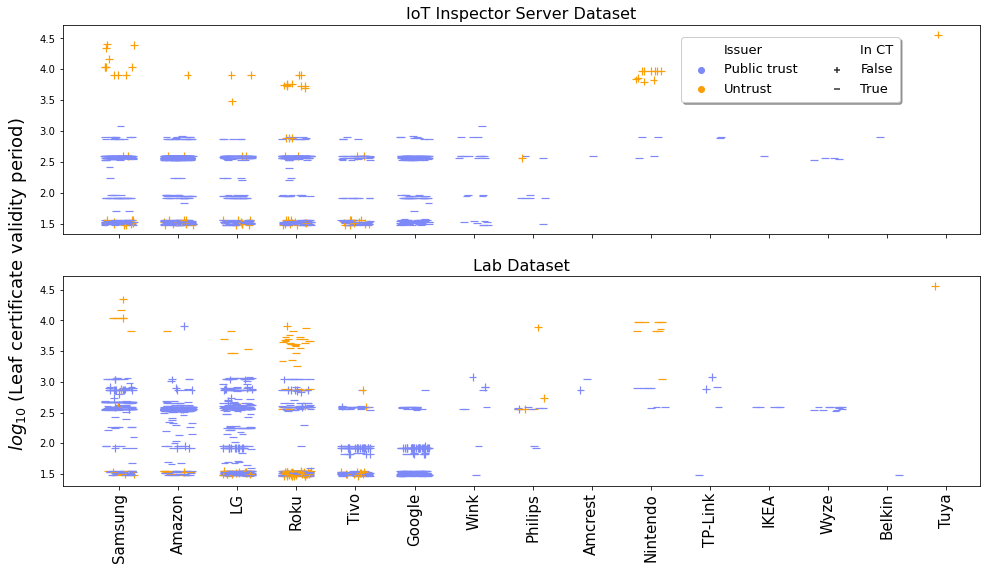

In [134]:
fig, axes = plt.subplots(2, figsize=(14, 8), sharex=True)
matplotlib.rc('ytick', labelsize=14)

ct_palette = ["#7E89F8", "#FA9F09"]
markers = {True: "_", False: "+"}

sns.scatterplot(data=iot_comm, x="jittered", y="certday_log10", hue="Issuer", style="In CT", ax=axes[0],\
                s=60, palette=ct_palette, markers=markers, alpha=1, linewidth=1.2, x_jitter=True)
sns.scatterplot(data=lab_comm, x="jittered", y="certday_log10", hue="Issuer", style="In CT", ax=axes[1], \
                s=60, palette=ct_palette, markers=markers, alpha=1, linewidth=1.2, x_jitter=True)

axes[0].set_xlabel("")
axes[0].set_ylabel("")
axes[1].set_xlabel("")
axes[1].set_ylabel("")
#axes[0].title.set_text('IoT Inspector Server Dataset', Fontsize=16)
axes[0].set_title("IoT Inspector Server Dataset", fontsize=16)
#axes[1].title.set_text('Lab Dataset', Fontsize=16)
axes[1].set_title("Lab Dataset", fontsize=16)

handles0, labels0 = axes[0].get_legend_handles_labels()
axes[0].legend(handles=handles0[0:], labels=labels0[0:], title="",\
                   loc="lower right", fancybox=True, framealpha=1, shadow=True, borderpad=.5, ncol=2, bbox_to_anchor=[0.92, 0.60], \
                   fontsize=13)

axes[1].get_legend().remove()

plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], fontsize=15)
axes[1].set_xticklabels(['Samsung', 'Amazon', 'LG', 'Roku', 'Tivo', \
                    'Google', 'Wink', 'Philips', 'Amcrest', 'Nintendo', \
                    'TP-Link', 'IKEA', 'Wyze', 'Belkin', 'Tuya'], \
                    fontsize=15, rotation=90, ha='right', va='center',rotation_mode='anchor')

fig.text(0.025, 0.5, '$log_{10}$ (Leaf certificate validity period)', va='center', rotation='vertical', fontsize=18)
plt.subplots_adjust(left=0.08, right=0.99, bottom=0.15, top=0.95)

#fig.tight_layout()
plt.show()

### Common Issuer, Same SNIs

In [135]:
iot_comm_sni = iot_comm.loc[iot_comm['server_name_indication'].isin(sni_commlis)]
lab_comm_sni = lab_comm.loc[lab_comm['server_name'].isin(sni_commlis)]

In [136]:
lab_comm_sni.loc[(lab_comm_sni['In CT'] == False) & (lab_comm_sni['Issuer'] == "Public trust")]

,server_name,certificate.serial,issuer_O,validity_days,mac,device_vendor,issuer_CN,subject_CN,validation_status,serial,In CT,Issuer,certday_log10,vendor_id,jittered
16,osb-ussvc.samsungqbe.com,A8B29861E641DF722AFAA99072176C5C,COMODO CA Limited,813,84:c0:ef:2f:42:cc,samsung,COMODO RSA Organization Validation Secure Server CA,*.samsungqbe.com,ok,A8B29861E641DF722AFAA99072176C5C,False,Public trust,2.910091,1,1.209161
32,www.mgo.com,9310935F50EBB897D4A2EDC4E693771F,COMODO CA Limited,730,84:c0:ef:2f:42:cc,samsung,COMODO RSA Organization Validation Secure Server CA,*.mgo.com,ok,9310935F50EBB897D4A2EDC4E693771F,False,Public trust,2.863323,1,0.923118
55,log-ingestion.samsungacr.com,9EBDDD0CB99954E6,GoDaddy.com,730,84:c0:ef:2f:42:cc,samsung,Go Daddy Secure Certificate Authority - G2,*.samsungacr.com,ok,9EBDDD0CB99954E6,False,Public trust,2.863323,1,0.952951
84,api.distribution.hulu.com,8090FE51DC1346FF1F18507F1A682348,Sectigo Limited,730,84:c0:ef:2f:42:cc,samsung,Sectigo RSA Organization Validation Secure Server CA,api.distribution.hulu.com,ok,8090FE51DC1346FF1F18507F1A682348,False,Public trust,2.863323,1,0.914417
174,gpm.samsungqbe.com,FA77B7D7A6FFF4DA8BDD3A538C5E2D4E,COMODO CA Limited,820,84:c0:ef:2f:42:cc,samsung,COMODO RSA Organization Validation Secure Server CA,*.samsungqbe.com,ok,FA77B7D7A6FFF4DA8BDD3A538C5E2D4E,False,Public trust,2.913814,1,0.852526
216,log-config.samsungacr.com,D76EE54416982D1E,GoDaddy.com,397,84:c0:ef:2f:42:cc,samsung,Go Daddy Secure Certificate Authority - G2,*.samsungacr.com,ok,D76EE54416982D1E,False,Public trust,2.598791,1,0.986327
226,www.google.com,D2AC57EBA83598450A0000000108AEDB,Google Trust Services LLC,83,84:c0:ef:2f:42:cc,samsung,GTS CA 1C3,www.google.com,ok,D2AC57EBA83598450A0000000108AEDB,False,Public trust,1.919078,1,0.925675
252,auth.hulu.com,D6F251B9325DA506BED7F9A34BC4EC42,COMODO CA Limited,1095,84:c0:ef:2f:42:cc,samsung,COMODO RSA Domain Validation Secure Server CA,auth.hulu.com,ok,D6F251B9325DA506BED7F9A34BC4EC42,False,Public trust,3.039414,1,0.930592
265,siloh.pluto.tv,CD87ED5233B2F1ECCA312576CFE38A1F,COMODO CA Limited,730,84:c0:ef:2f:42:cc,samsung,COMODO RSA Domain Validation Secure Server CA,siloh.pluto.tv,ok,CD87ED5233B2F1ECCA312576CFE38A1F,False,Public trust,2.863323,1,1.222373
268,sb.scorecardresearch.com,E6CC1314B397DBD158E3B494FE2889C6,COMODO CA Limited,393,84:c0:ef:2f:42:cc,samsung,COMODO RSA Organization Validation Secure Server CA,*.scorecardresearch.com,ok,E6CC1314B397DBD158E3B494FE2889C6,False,Public trust,2.594393,1,0.931168


In [137]:
vendor_ids = {'amazon':1, 'samsung':2, 'lg':3, 'roku':4, \
             'google':5, 'tivo':6, 'philips':7, 'nintendo':8, \
             'wink':9, 'wyze':10, 'tplink':11, 'tuya':12, 'ikea':13}

iot_comm_sni['vendor_id'] = iot_comm_sni['device_vendor'].apply(lambda x: vendor_ids[x])
iot_comm_sni['jittered'] = iot_comm_sni['vendor_id'].apply(lambda x: jitter(x))
lab_comm_sni['vendor_id'] = lab_comm_sni['device_vendor'].apply(lambda x: vendor_ids[x])
lab_comm_sni['jittered'] = lab_comm_sni['vendor_id'].apply(lambda x: jitter(x))

<ipython-input-137-c87d9b8e2fc7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iot_comm_sni['vendor_id'] = iot_comm_sni['device_vendor'].apply(lambda x: vendor_ids[x])
<ipython-input-137-c87d9b8e2fc7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iot_comm_sni['jittered'] = iot_comm_sni['vendor_id'].apply(lambda x: jitter(x))
<ipython-input-137-c87d9b8e2fc7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

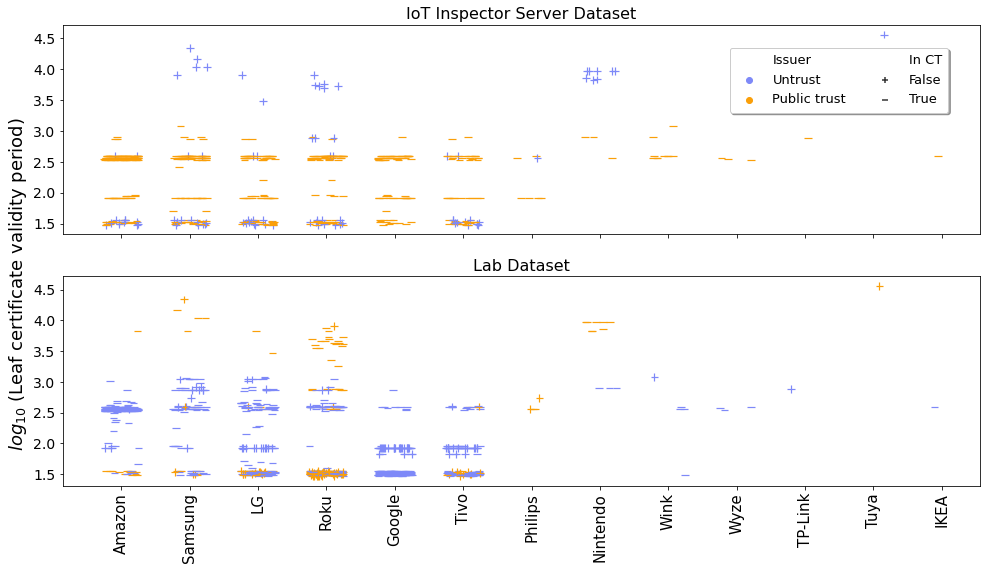

In [138]:
fig, axes = plt.subplots(2, figsize=(14, 8), sharex=True)
matplotlib.rc('ytick', labelsize=14)

ct_palette = ["#7E89F8", "#FA9F09"]
markers = {True: "_", False: "+"}

sns.scatterplot(data=iot_comm_sni, x="jittered", y="certday_log10", hue="Issuer", style="In CT", ax=axes[0],\
                s=60, palette=ct_palette, markers=markers, alpha=1, linewidth=1.2, x_jitter=True)
sns.scatterplot(data=lab_comm_sni, x="jittered", y="certday_log10", hue="Issuer", style="In CT", ax=axes[1], \
                s=60, palette=ct_palette, markers=markers, alpha=1, linewidth=1.2, x_jitter=True)

axes[0].set_xlabel("")
axes[0].set_ylabel("")
axes[1].set_xlabel("")
axes[1].set_ylabel("")
#axes[0].title.set_text('IoT Inspector Server Dataset', Fontsize=16)
axes[0].set_title("IoT Inspector Server Dataset", fontsize=16)
#axes[1].title.set_text('Lab Dataset', Fontsize=16)
axes[1].set_title("Lab Dataset", fontsize=16)

handles0, labels0 = axes[0].get_legend_handles_labels()
axes[0].legend(handles=handles0[0:], labels=labels0[0:], title="",\
                   fancybox=True, framealpha=1, shadow=True, borderpad=.5, ncol=2, bbox_to_anchor=[0.72, 0.55], \
                   fontsize=13)

axes[1].get_legend().remove()

plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13], fontsize=15)
axes[1].set_xticklabels(['Amazon', 'Samsung', 'LG', 'Roku', \
                    'Google', 'Tivo', 'Philips', 'Nintendo', 'Wink',\
                    'Wyze', 'TP-Link', 'Tuya', 'IKEA'], \
                    fontsize=15, rotation=90, ha='right', va='center',rotation_mode='anchor')

fig.text(0.025, 0.5, '$log_{10}$ (Leaf certificate validity period)', va='center', rotation='vertical', fontsize=18)
plt.subplots_adjust(left=0.08, right=0.99, bottom=0.15, top=0.95)

#fig.tight_layout()
plt.show()

### Different SNIs

In [139]:
lab_diff_plot = lab_sub.loc[lab_sub['server_name'].isin(diffsni_lablis)]

In [140]:
iot_diff_plot = iot_sub.loc[iot_sub['server_name_indication'].isin(diffsni_iotlis)]

In [141]:
publis = ['Amazon', "COMODO CA Limited", "DigiCert Inc", "GoDaddy.com", "Sectigo Limited", "GlobalSign nv-sa", \
          "Entrust", "Google Trust Services LLC", "Let's Encrypt", "Cloudflare", "Network Solutions L.L.C.", \
          "Microsoft Corporation", "ZeroSSL", "Apple Inc.", "Cloudflare", "Trustwave Holdings", "Comodo Japan", \
          "Google Trust Services", "Symantec Corporation", "thawte", "Google Inc", "GeoTrust Inc.", "Gandi", \
          "IPS Certification Authority s.l.", "CloudFlare"]

In [142]:
iot_diff_plot['Issuer'] = iot_diff_plot['issuer_O'].apply(lambda x: "Public trust" if x in publis else "Untrust")
lab_diff_plot['Issuer'] = lab_diff_plot['issuer_O'].apply(lambda x: "Public trust" if x in publis else "Untrust")

<ipython-input-142-972fef2a1448>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iot_diff_plot['Issuer'] = iot_diff_plot['issuer_O'].apply(lambda x: "Public trust" if x in publis else "Untrust")
<ipython-input-142-972fef2a1448>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lab_diff_plot['Issuer'] = lab_diff_plot['issuer_O'].apply(lambda x: "Public trust" if x in publis else "Untrust")


In [143]:
iot_diff_plot['certday_log10'] = iot_diff_plot['validity_days'].apply(lambda x: np.log10(x))

<ipython-input-143-dd7e01590c1a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iot_diff_plot['certday_log10'] = iot_diff_plot['validity_days'].apply(lambda x: np.log10(x))


In [144]:
lab_diff_plot['certday_log10'] = lab_diff_plot['validity_days'].apply(lambda x: np.log10(x))

<ipython-input-144-e0b4df96c20a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lab_diff_plot['certday_log10'] = lab_diff_plot['validity_days'].apply(lambda x: np.log10(x))


In [145]:
iot_diff_plot = iot_diff_plot.drop_duplicates(['device_vendor', 'cert_serialNum_from_x509af', 'issuer_CN', 'certday_log10'])
lab_diff_plot = lab_diff_plot.drop_duplicates(['device_vendor', 'serial', 'issuer_CN', 'certday_log10'])

In [146]:
def jitter(x):
    return x + random.uniform(0, .5) - .25

In [147]:
iot_diff_plot = iot_diff_plot.rename({"response": "In CT"}, axis=1)
lab_diff_plot = lab_diff_plot.rename({"res": "In CT"}, axis=1)

In [148]:
iot_diff_plot['device_vendor'].value_counts()

amazon      145
samsung     122
google      101
roku         98
lg           81
xiaomi       49
tivo         27
tplink       21
wink         19
amcrest       4
philips       2
ikea          2
nintendo      1
belkin        1
Name: device_vendor, dtype: int64

In [149]:
lab_diff_plot['device_vendor'].value_counts()

lg          294
samsung     170
amazon      151
roku         77
google       66
tivo         44
philips      13
wyze         13
belkin       13
nintendo     10
wink          7
ikea          6
tuya          3
withings      1
tplink        1
Name: device_vendor, dtype: int64

In [150]:
vendor_ids = {'amazon':1, 'samsung':2, 'google':3, 'roku':4, 'lg':5, \
             'xiaomi':6, 'tivo':7, 'tplink':8, 'wink':9, 'amcrest':10, \
             'philips':11, 'ikea':12, 'belkin':13, 'nintendo':14, 'withings':15, 'wyze':16, 'tuya':17}

iot_diff_plot['vendor_id'] = iot_diff_plot['device_vendor'].apply(lambda x: vendor_ids[x])
iot_diff_plot['jittered'] = iot_diff_plot['vendor_id'].apply(lambda x: jitter(x))
lab_diff_plot['vendor_id'] = lab_diff_plot['device_vendor'].apply(lambda x: vendor_ids[x])
lab_diff_plot['jittered'] = lab_diff_plot['vendor_id'].apply(lambda x: jitter(x))

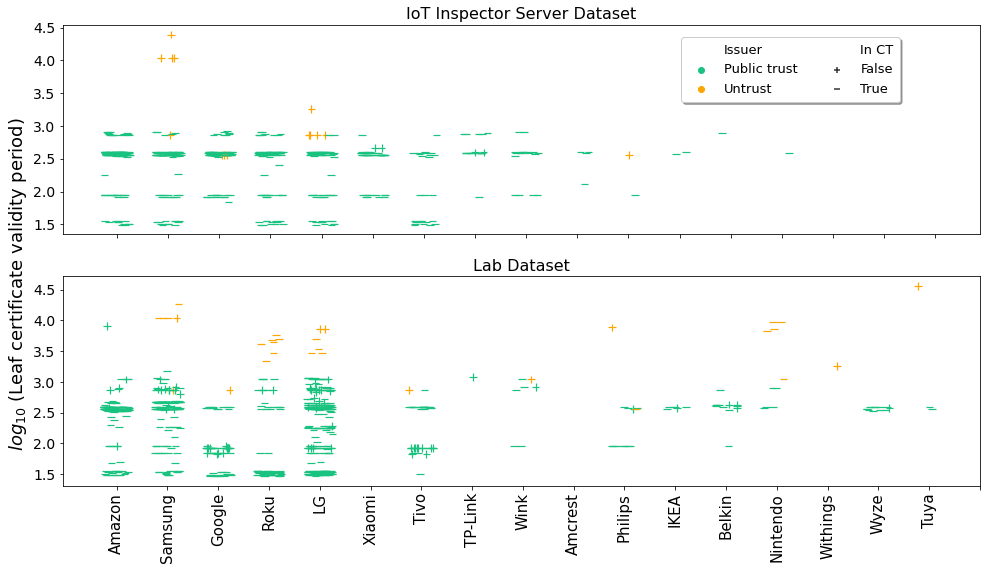

In [151]:
fig, axes = plt.subplots(2, figsize=(14, 8), sharex=True)
matplotlib.rc('ytick', labelsize=14)

ct_palette = ["#1AC280", "#FDA501"]
markers = {True: "_", False: "+"}

sns.scatterplot(data=iot_diff_plot, x="jittered", y="certday_log10", hue="Issuer", style="In CT", ax=axes[0],\
                s=60, palette=ct_palette, markers=markers, alpha=1, linewidth=1.2, x_jitter=True)
sns.scatterplot(data=lab_diff_plot, x="jittered", y="certday_log10", hue="Issuer", style="In CT", ax=axes[1], \
                s=60, palette=ct_palette, markers=markers, alpha=1, linewidth=1.2, x_jitter=True)

axes[0].set_xlabel("")
axes[0].set_ylabel("")
axes[1].set_xlabel("")
axes[1].set_ylabel("")
#axes[0].title.set_text('IoT Inspector Server Dataset', Fontsize=16)
axes[0].set_title("IoT Inspector Server Dataset", fontsize=16)
#axes[1].title.set_text('Lab Dataset', Fontsize=16)
axes[1].set_title("Lab Dataset", fontsize=16)

handles0, labels0 = axes[0].get_legend_handles_labels()
axes[0].legend(handles=handles0[0:], labels=labels0[0:], title="",\
                   loc="lower right", fancybox=True, framealpha=1, shadow=True, borderpad=.5, ncol=2, bbox_to_anchor=[0.92, 0.60], \
                   fontsize=13)

axes[1].get_legend().remove()

plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18], fontsize=15)
axes[1].set_xticklabels(['Amazon', 'Samsung', 'Google', 'Roku', 'LG', \
                         'Xiaomi', 'Tivo', 'TP-Link', 'Wink', 'Amcrest', \
                         'Philips', 'IKEA', 'Belkin', 'Nintendo', 'Withings', 'Wyze', 'Tuya', ''], \
                        fontsize=15, rotation=90, ha='right', va='center',rotation_mode='anchor')

fig.text(0.025, 0.5, '$log_{10}$ (Leaf certificate validity period)', va='center', rotation='vertical', fontsize=18)
plt.subplots_adjust(left=0.08, right=0.99, bottom=0.15, top=0.95)

#fig.tight_layout()
plt.show()

### Different issuers

In [152]:
iot2_samsung = iot_sub.loc[(iot_sub['device_vendor'] == 'samsung') & (~iot_sub['issuer_O'].isin(samsung_comm))]
iot2_amazon = iot_sub.loc[(iot_sub['device_vendor'] == 'amazon') & (~iot_sub['issuer_O'].isin(amazon_comm))]
iot2_lg = iot_sub.loc[(iot_sub['device_vendor'] == 'lg') & (~iot_sub['issuer_O'].isin(lg_comm))]
iot2_roku = iot_sub.loc[(iot_sub['device_vendor'] == 'roku') & (~iot_sub['issuer_O'].isin(roku_comm))]
iot2_tivo = iot_sub.loc[(iot_sub['device_vendor'] == 'tivo') & (~iot_sub['issuer_O'].isin(tivo_comm))]
iot2_google = iot_sub.loc[(iot_sub['device_vendor'] == 'google') & (~iot_sub['issuer_O'].isin(google_comm))]
iot2_wink = iot_sub.loc[(iot_sub['device_vendor'] == 'wink') & (~iot_sub['issuer_O'].isin(wink_comm))]
iot2_xiaomi = iot_sub.loc[(iot_sub['device_vendor'] == 'xiaomi')]
iot2_philips = iot_sub.loc[(iot_sub['device_vendor'] == 'philips') & (~iot_sub['issuer_O'].isin(philips_comm))]
iot2_amcrest = iot_sub.loc[(iot_sub['device_vendor'] == 'amcrest') & (~iot_sub['issuer_O'].isin(amcrest_comm))]
iot2_nintendo = iot_sub.loc[(iot_sub['device_vendor'] == 'nintendo') & (~iot_sub['issuer_O'].isin(nintendo_comm))]
iot2_tplink = iot_sub.loc[(iot_sub['device_vendor'] == 'tplink') & (~iot_sub['issuer_O'].isin(tplink_comm))]
iot2_ikea = iot_sub.loc[(iot_sub['device_vendor'] == 'ikea') & (~iot_sub['issuer_O'].isin(ikea_comm))]
iot2_withings = iot_sub.loc[(iot_sub['device_vendor'] == 'withings')]
iot2_wyze = iot_sub.loc[(iot_sub['device_vendor'] == 'wyze') & (~iot_sub['issuer_O'].isin(wyze_comm))]
iot2_belkin = iot_sub.loc[(iot_sub['device_vendor'] == 'belkin') & (~iot_sub['issuer_O'].isin(belkin_comm))]
iot2_tuya = iot_sub.loc[(iot_sub['device_vendor'] == 'tuya') & (~iot_sub['issuer_O'].isin(tuya_comm))]

In [153]:
iot_diff = pd.concat([iot2_samsung, iot2_amazon, iot2_lg, iot2_roku, iot2_tivo, iot2_google, iot2_wink, iot2_xiaomi, iot2_withings, \
                      iot2_philips, iot2_amcrest, iot2_nintendo, iot2_tplink, iot2_ikea, iot2_wyze, iot2_belkin, iot2_tuya], ignore_index=True)

In [154]:
lab2_samsung = lab_sub.loc[(lab_sub['device_vendor'] == 'samsung') & (~lab_sub['issuer_O'].isin(samsung_comm))]
lab2_amazon = lab_sub.loc[(lab_sub['device_vendor'] == 'amazon') & (~lab_sub['issuer_O'].isin(amazon_comm))]
lab2_lg = lab_sub.loc[(lab_sub['device_vendor'] == 'lg') & (~lab_sub['issuer_O'].isin(lg_comm))]
lab2_roku = lab_sub.loc[(lab_sub['device_vendor'] == 'roku') & (~lab_sub['issuer_O'].isin(roku_comm))]
lab2_tivo = lab_sub.loc[(lab_sub['device_vendor'] == 'tivo') & (~lab_sub['issuer_O'].isin(tivo_comm))]
lab2_google = lab_sub.loc[(lab_sub['device_vendor'] == 'google') & (~lab_sub['issuer_O'].isin(google_comm))]
lab2_wink = lab_sub.loc[(lab_sub['device_vendor'] == 'wink') & (~lab_sub['issuer_O'].isin(wink_comm))]
lab2_xiaomi = lab_sub.loc[(lab_sub['device_vendor'] == 'xiaomi')]
lab2_philips = lab_sub.loc[(lab_sub['device_vendor'] == 'philips') & (~lab_sub['issuer_O'].isin(philips_comm))]
lab2_amcrest = lab_sub.loc[(lab_sub['device_vendor'] == 'amcrest') & (~lab_sub['issuer_O'].isin(amcrest_comm))]
lab2_nintendo = lab_sub.loc[(lab_sub['device_vendor'] == 'nintendo') & (~lab_sub['issuer_O'].isin(nintendo_comm))]
lab2_tplink = lab_sub.loc[(lab_sub['device_vendor'] == 'tplink') & (~lab_sub['issuer_O'].isin(tplink_comm))]
lab2_ikea = lab_sub.loc[(lab_sub['device_vendor'] == 'ikea') & (~lab_sub['issuer_O'].isin(ikea_comm))]
lab2_withings = lab_sub.loc[(lab_sub['device_vendor'] == 'withings')]
lab2_wyze = lab_sub.loc[(lab_sub['device_vendor'] == 'wyze') & (~lab_sub['issuer_O'].isin(wyze_comm))]
lab2_belkin = lab_sub.loc[(lab_sub['device_vendor'] == 'belkin') & (~lab_sub['issuer_O'].isin(belkin_comm))]
lab2_tuya = lab_sub.loc[(lab_sub['device_vendor'] == 'tuya') & (~lab_sub['issuer_O'].isin(tuya_comm))]

In [155]:
lab_diff = pd.concat([lab2_samsung, lab2_amazon, lab2_lg, lab2_roku, lab2_tivo, lab2_google, lab2_wink, lab2_xiaomi, lab2_withings, \
                      lab2_philips, lab2_amcrest, lab2_nintendo, lab2_tplink, lab2_ikea, lab2_wyze, lab2_belkin, lab2_tuya], ignore_index=True)

In [156]:
publis = ['Amazon', "COMODO CA Limited", "DigiCert Inc", "GoDaddy.com", "Sectigo Limited", "GlobalSign nv-sa", \
          "Entrust", "Google Trust Services LLC", "Let's Encrypt", "Cloudflare", "Network Solutions L.L.C.", \
          "Microsoft Corporation", "ZeroSSL", "Apple Inc.", "Trustwave Holdings", "Comodo Japan", "DigiCert", \
          "Google Trust Services", "Symantec Corporation", "Google Inc", "thawte", "GeoTrust Inc.", "IPS Certification Authority s.l.", \
          "Gandi", "CloudFlare"]

In [157]:
iot_diff['Issuer'] = iot_diff['issuer_O'].apply(lambda x: "Public trust" if x in publis else "Untrust")

In [158]:
lab_diff['Issuer'] = lab_diff['issuer_O'].apply(lambda x: "Public trust" if x in publis else "Untrust")

In [159]:
iot_diff['certday_log10'] = iot_diff['validity_days'].apply(lambda x: np.log10(x))

In [160]:
lab_diff['certday_log10'] = lab_diff['validity_days'].apply(lambda x: np.log10(x))

In [162]:
iot_diff = iot_diff.drop_duplicates(['device_vendor', 'cert_serialNum_from_x509af', 'issuer_CN', 'validity_days'])
lab_diff = lab_diff.drop_duplicates(['device_vendor', 'serial', 'issuer_CN', 'validity_days'])

In [163]:
def jitter(x):
    return x + random.uniform(0, .5) - .25

In [164]:
iot_diff = iot_diff.rename({"response": "In CT"}, axis=1)
lab_diff = lab_diff.rename({"res": "In CT"}, axis=1)

In [165]:
vendor_ids = {'samsung':1, 'amazon':2, 'lg':3, 'roku':4, 'tivo':5, \
             'google':6, 'wink':7, "xiaomi":8, 'philips':9, 'amcrest':10, 'nintendo':11, \
             'tplink':12, 'ikea':13, 'withings':14, 'wyze':15, 'belkin':16, 'tuya':17}

iot_diff['vendor_id'] = iot_diff['device_vendor'].apply(lambda x: vendor_ids[x])
iot_diff['jittered'] = iot_diff['vendor_id'].apply(lambda x: jitter(x))
lab_diff['vendor_id'] = lab_diff['device_vendor'].apply(lambda x: vendor_ids[x])
lab_diff['jittered'] = lab_diff['vendor_id'].apply(lambda x: jitter(x))

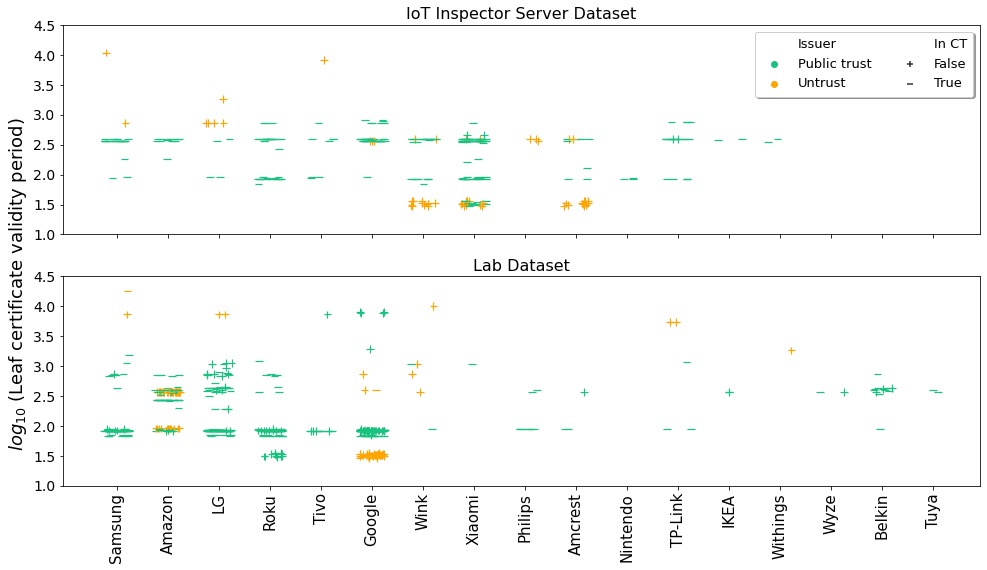

In [166]:
fig, axes = plt.subplots(2, figsize=(14, 8), sharex=True)
matplotlib.rc('ytick', labelsize=14)

ct_palette = ["#1AC280", "#FDA501"]
markers = {True: "_", False: "+"}

sns.scatterplot(data=iot_diff, x="jittered", y="certday_log10", hue="Issuer", style="In CT", ax=axes[0],\
                s=60, palette=ct_palette, markers=markers, alpha=1, linewidth=1.2, x_jitter=True)
sns.scatterplot(data=lab_diff, x="jittered", y="certday_log10", hue="Issuer", style="In CT", ax=axes[1], \
                s=60, palette=ct_palette, markers=markers, alpha=1, linewidth=1.2, x_jitter=True)

axes[0].set_ylim([1.0, 4.5])
axes[1].set_ylim([1.0, 4.5])
axes[0].set_xlabel("")
axes[0].set_ylabel("")
axes[1].set_xlabel("")
axes[1].set_ylabel("")
#axes[0].title.set_text('IoT Inspector Server Dataset', Fontsize=16)
axes[0].set_title("IoT Inspector Server Dataset", fontsize=16)
#axes[1].title.set_text('Lab Dataset', Fontsize=16)
axes[1].set_title("Lab Dataset", fontsize=16)

handles0, labels0 = axes[0].get_legend_handles_labels()
axes[0].legend(handles=handles0[0:], labels=labels0[0:], title="",\
                   loc="upper right", fancybox=True, framealpha=1, shadow=True, borderpad=.5, ncol=2, \
                   fontsize=13)

axes[1].get_legend().remove()

plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17], fontsize=15)
axes[1].set_xticklabels(['Samsung', 'Amazon', 'LG', 'Roku', 'Tivo', \
                    'Google', 'Wink', 'Xiaomi', 'Philips', 'Amcrest', 'Nintendo', \
                    'TP-Link', 'IKEA', 'Withings', 'Wyze', 'Belkin', 'Tuya'], \
                    fontsize=15, rotation=90, ha='right', va='center',rotation_mode='anchor')

fig.text(0.025, 0.5, '$log_{10}$ (Leaf certificate validity period)', va='center', rotation='vertical', fontsize=18)
plt.subplots_adjust(left=0.08, right=0.99, bottom=0.15, top=0.95)

#fig.tight_layout()
plt.show()